In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import gridspec
import scipy
import scipy.stats as stats
from ipywidgets.widgets.interaction import interact

In [2]:
continuous_distributions = "/media/sf_Shared_Linux/recurrence_interval/continuous_distributions.csv"
dists_unindexed = pd.read_csv(continuous_distributions)
dist_list = dists_unindexed.distribution.tolist()
dists = dists_unindexed.set_index(dists_unindexed.distribution)

In [3]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8638610/high_low"
working_fil = '8638610_hl.csv'
os.chdir(working_dir)         
Data = pd.read_csv(working_fil, 
                   delimiter=',',
                   usecols=(0,1,2),
                   infer_datetime_format=True,
                   skiprows=0
                  )
Data.columns = ['datetime','water_level','ty']
Data['datetime'] = Data['datetime'].apply(pd.to_datetime)
Data.head(5)

datetime  water_level  ty
0 1983-01-01 02:42:00       -0.200  H 
1 1983-01-01 09:12:00       -3.340  LL
2 1983-01-01 15:24:00        0.351  HH
3 1983-01-01 21:54:00       -3.258  L 
4 1983-01-02 03:48:00       -0.358  H

In [4]:
Data.set_index('datetime', inplace=True)

In [5]:
df = Data[Data.ty == 'HH']

In [6]:
print(len(df.water_level))
print(len(Data.water_level))
19./6706

6706
26820


0.0028332836266030423

In [7]:
#plt.hist(Data.water_level[Data.ty == 'HH'],normed=1,bins=100)

In [8]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [9]:
def save_figure(path,name):
    plt.savefig(path+name+".png",
                dpi=200,
                facecolor='white',
                edgecolor='white'
               )

In [26]:
def dist_fit(dist_name,binsize):
    #If your data is in an excel spreadsheet save it as a delimited text file (.csv formatted)
    #filename = path+name+".txt"
    #df = pd.read_csv(filename,names=["Hs","File"])           
    title ='Sewells Point, VA\nv-datum = MHHW'
    
    #Initialize figure and set dimensions
    fig = plt.figure(figsize = (18,6))
    gs = gridspec.GridSpec(2,2)
    ax1 = fig.add_subplot(gs[:,0])
    ax3 = fig.add_subplot(gs[:,1])
    ax1.set_title(title,fontsize=20)
    
    #Remove the plot frame lines. They are unnecessary chartjunk.
    ax1.spines["top"].set_visible(False)  
    ax1.spines["right"].set_visible(False) 
    ax3.spines["top"].set_visible(False)  
    ax3.spines["right"].set_visible(False) 
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax1.get_xaxis().tick_bottom()  
    ax1.get_yaxis().tick_left()  
    ax3.get_xaxis().tick_bottom()  
    ax3.get_yaxis().tick_left()  
    
    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    ax1.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",labelsize=14)
    ax3.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",labelsize=14)

    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    ax1.set_xlabel("HH (ft)", fontsize=16)  
    ax1.set_ylabel("Frequency of occurence", fontsize=16)  
    ax3.set_xlabel("HH (ft)", fontsize=16) 
    ax3.set_ylabel("Probability HH < x", fontsize=16)
    #set x-axis limits
    ax1.set_xlim(-3,3)
    ax3.set_xlim(-3,3)
    #Setting .... variables
    size    = len(df.water_level)
    max_val = 2*max(df.water_level)
    x0 = np.arange(-max_val,max_val,max_val*0.0001)
    x1 = np.arange(-3,3,binsize)
    y1 = df.water_level
    #Plot histograms
    EPDF = ax1.hist(y1, bins=x1, color='darkorange', histtype='step')
    ECDF = ax3.hist(y1, bins=x1, color='darkorange', histtype='step', normed=1, cumulative=True)
    #Fitting distribution
    dist  = getattr(scipy.stats, dist_name)
    param = dist.fit(y1)
    pdf_fitted = dist.pdf(x0, *param[:-2], loc=param[-2], scale=param[-1])*size*binsize
    cdf_fitted = dist.cdf(x0, *param[:-2], loc=param[-2], scale=param[-1])
    
    #Checking goodness of fit
    #ks_fit = stats.kstest(pdf_fitted,dist_name) # Kolmogorov-Smirnov test: returns [KS stat (D,D+,orD-),pvalue]
    #print(ks_fit)
    
    #Finding location of 0.002 and 0.01 exceedence probability events 
    OneYearProb  = 1 - 19.0/len(df.water_level)
    OneMonthProb = 1 - 12*19.0/len(df.water_level)
    OneYearInd   = find_nearest(cdf_fitted,OneYearProb)
    OneMonthInd  = find_nearest(cdf_fitted,OneMonthProb)
    #Plotting pdf and cdf    
    #ax1.plot(x0,pdf_fitted,linewidth=2,label=dist_name)
    #ax3.plot(x0,cdf_fitted,linewidth=2,label=dist_name)
    #update figure spacing
    gs.update(wspace=0.1, hspace=0.2)
    #adding a text box
    ax3.text(-2.9,0.9,
             dist_name.upper()+" distribution\n"
             +"\n"
             +r"King Tide   : " + str("%.2f" %x0[OneYearInd])+ " feet\n"
             +r"Spring Tide: " + str("%.2f" %x0[OneMonthInd]) + " feet",
             fontsize=14
            )

    print(dists.loc[dist_name,'description']+"\n")
    print('Distribution parameters: '+str(param)+"\n\n")
    save_figure('/media/sf_Shared_Linux/recurrence_interval/','Sewells_Point')
    plt.show()

An alpha continuous random variable.

Distribution parameters: (21.163980642350431, -13.079396894109628, 276.19358068426686)




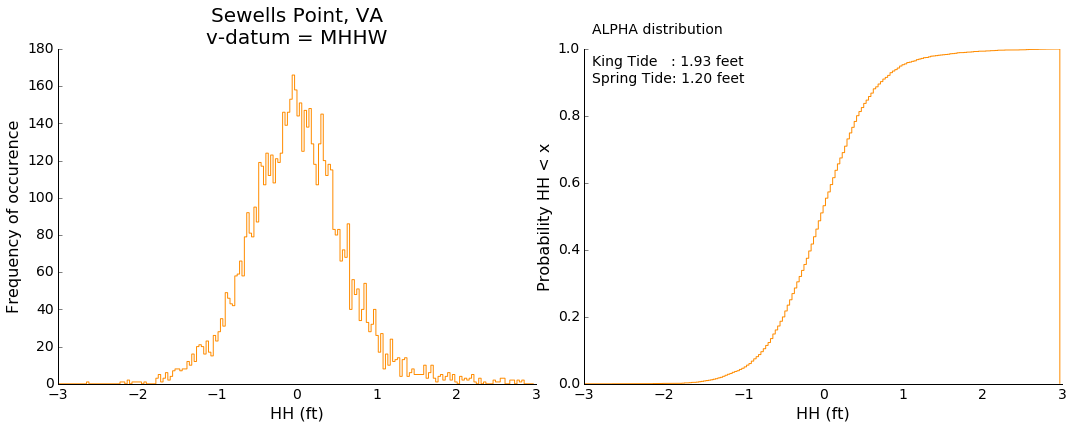

<function __main__.dist_fit>

In [29]:
interact(dist_fit, dist_name=dist_list,binsize=0.03)

In [19]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequency of
        arrays 

In [8]:

water_level = Data['water_level'].tolist()
maximum_water_level=[]
for i in range(len(water_level)//656):
    maxwater = max(water_level[(i*656):((i+1)*656)])
    maximum_water_level.append(maxwater)

In [9]:
len(maximum_water_level)

40

In [12]:
years = range(1983,2002,1)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [13]:
maximums=[]
for year in years:
    for month in months:
        date = str(month+' '+str(year))
        monthlymax = (date,float(str('%.3f' %Data.water_level[date].max())))
        maximums.append(monthlymax)

In [14]:
max_water_levels = dict(maximums)

In [15]:
max_water_levels['January 2001']

0.502

In [16]:
df = pd.DataFrame(max_water_levels.items(), columns=['Date', 'waterlevel'])

In [17]:
df.waterlevel.max()

3.819

In [18]:
len(max_water_levels)

228

(array([ 0.25261031,  0.25261031,  0.42101718,  0.75783092,  0.50522061,
         0.50522061,  0.50522061,  0.08420344,  0.        ,  0.08420344]),
 array([ 0.85  ,  1.1469,  1.4438,  1.7407,  2.0376,  2.3345,  2.6314,
         2.9283,  3.2252,  3.5221,  3.819 ]),
 <a list of 10 Patch objects>)

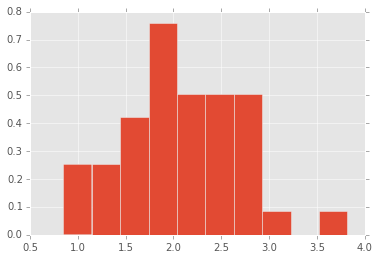

In [19]:
plt.hist(maximum_water_level,normed=1)

(array([ 0.20957624,  0.59379934,  0.75680308,  0.37257998,  0.27943498,
         0.24450561,  0.09314499,  0.06985875,  0.02328625,  0.01164312]),
 array([ 0.052 ,  0.4287,  0.8054,  1.1821,  1.5588,  1.9355,  2.3122,
         2.6889,  3.0656,  3.4423,  3.819 ]),
 <a list of 10 Patch objects>)

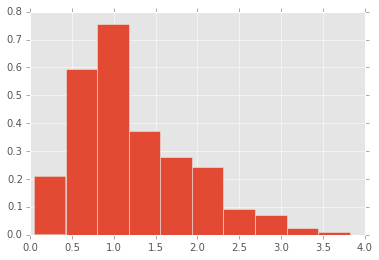

In [20]:
plt.hist(df.waterlevel[~np.isnan(df.waterlevel)],normed=1)

In [21]:
~np.isnan(df.waterlevel)

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
       ... 
198    True
199    True
200    True
201    True
202    True
203    True
204    True
205    True
206    True
207    True
208    True
209    True
210    True
211    True
212    True
213    True
214    True
215    True
216    True
217    True
218    True
219    True
220    True
221    True
222    True
223    True
224    True
225    True
226    True
227    True
Name: waterlevel, dtype: bool